In [1]:
import torch
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from tqdm import tqdm
from modules.losses import SupConLoss
from modules.backbones import ResNet50
from modules.datasets import MultiLabelDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver
from modules.trainer import Trainer
import torch.utils.data

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/embedding_size"

C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this Notebook we will compare different embeddings sizes.

In [2]:
dataset = MultiLabelDataset(
    "./tiny-imagenet-200/train",
    cache_in_ram=True,
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    max_classes=50
    )
len(dataset)

25000

In [3]:
#Build the DataLoaders
BATCH_SIZE = 128
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size],generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,pin_memory=True)

In [4]:
#Train the Models
Epochs = 5
sizes = [64,128,256,512,1024,2048]
for size in sizes: 
    siamese_model = ContrastiveNetwork(ResNet50(pretrained=True,freeze=False,embedding_size=size),SupConLoss())
    
    model_dir = os.path.join(SAVE_DIR,str(size))
    if os.path.isdir(model_dir):
        continue
    os.makedirs(model_dir,exist_ok=True)
    
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)


    trainer = Trainer(max_epochs=Epochs,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=siamese_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    lossTracker.save(model_dir)
    torch.cuda.empty_cache()
    gc.collect()

In [5]:
from modules.knn import KNN

knns = {}

for size in sizes: 
    model:torch.nn.Module = ResNet50(embedding_size=size)
    size_name = str(size)
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,size_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)
    knns[size_name] = KNN(model,train_loader,os.path.join(SAVE_DIR,size_name))

In [6]:
results = {}

for size in sizes: 
    model:torch.nn.Module = ResNet50(embedding_size=size)
    size_name = str(size)
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,size_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)

    embeddings = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader,size_name):
            img,label = batch
            embedding = model(img.to(DEVICE)).cpu().numpy()
            embeddings.append(embedding)  
            labels.append(label)
    
    results[size_name] = (np.vstack(embeddings),np.vstack(labels).reshape(-1))

2048: 100%|██████████| 40/40 [00:00<00:00, 55.94it/s]


In [7]:
from sklearn.metrics import f1_score  

for key in results:
    embeddings,labels = results[key]
    predictions = knns[key].querry_labels(embeddings)
    print(f"{key} F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

64 F1-Score: 0.654
128 F1-Score: 0.683
256 F1-Score: 0.712
512 F1-Score: 0.719
1024 F1-Score: 0.724
2048 F1-Score: 0.731


Building T-SNE plots: 6it [00:37,  6.20s/it]


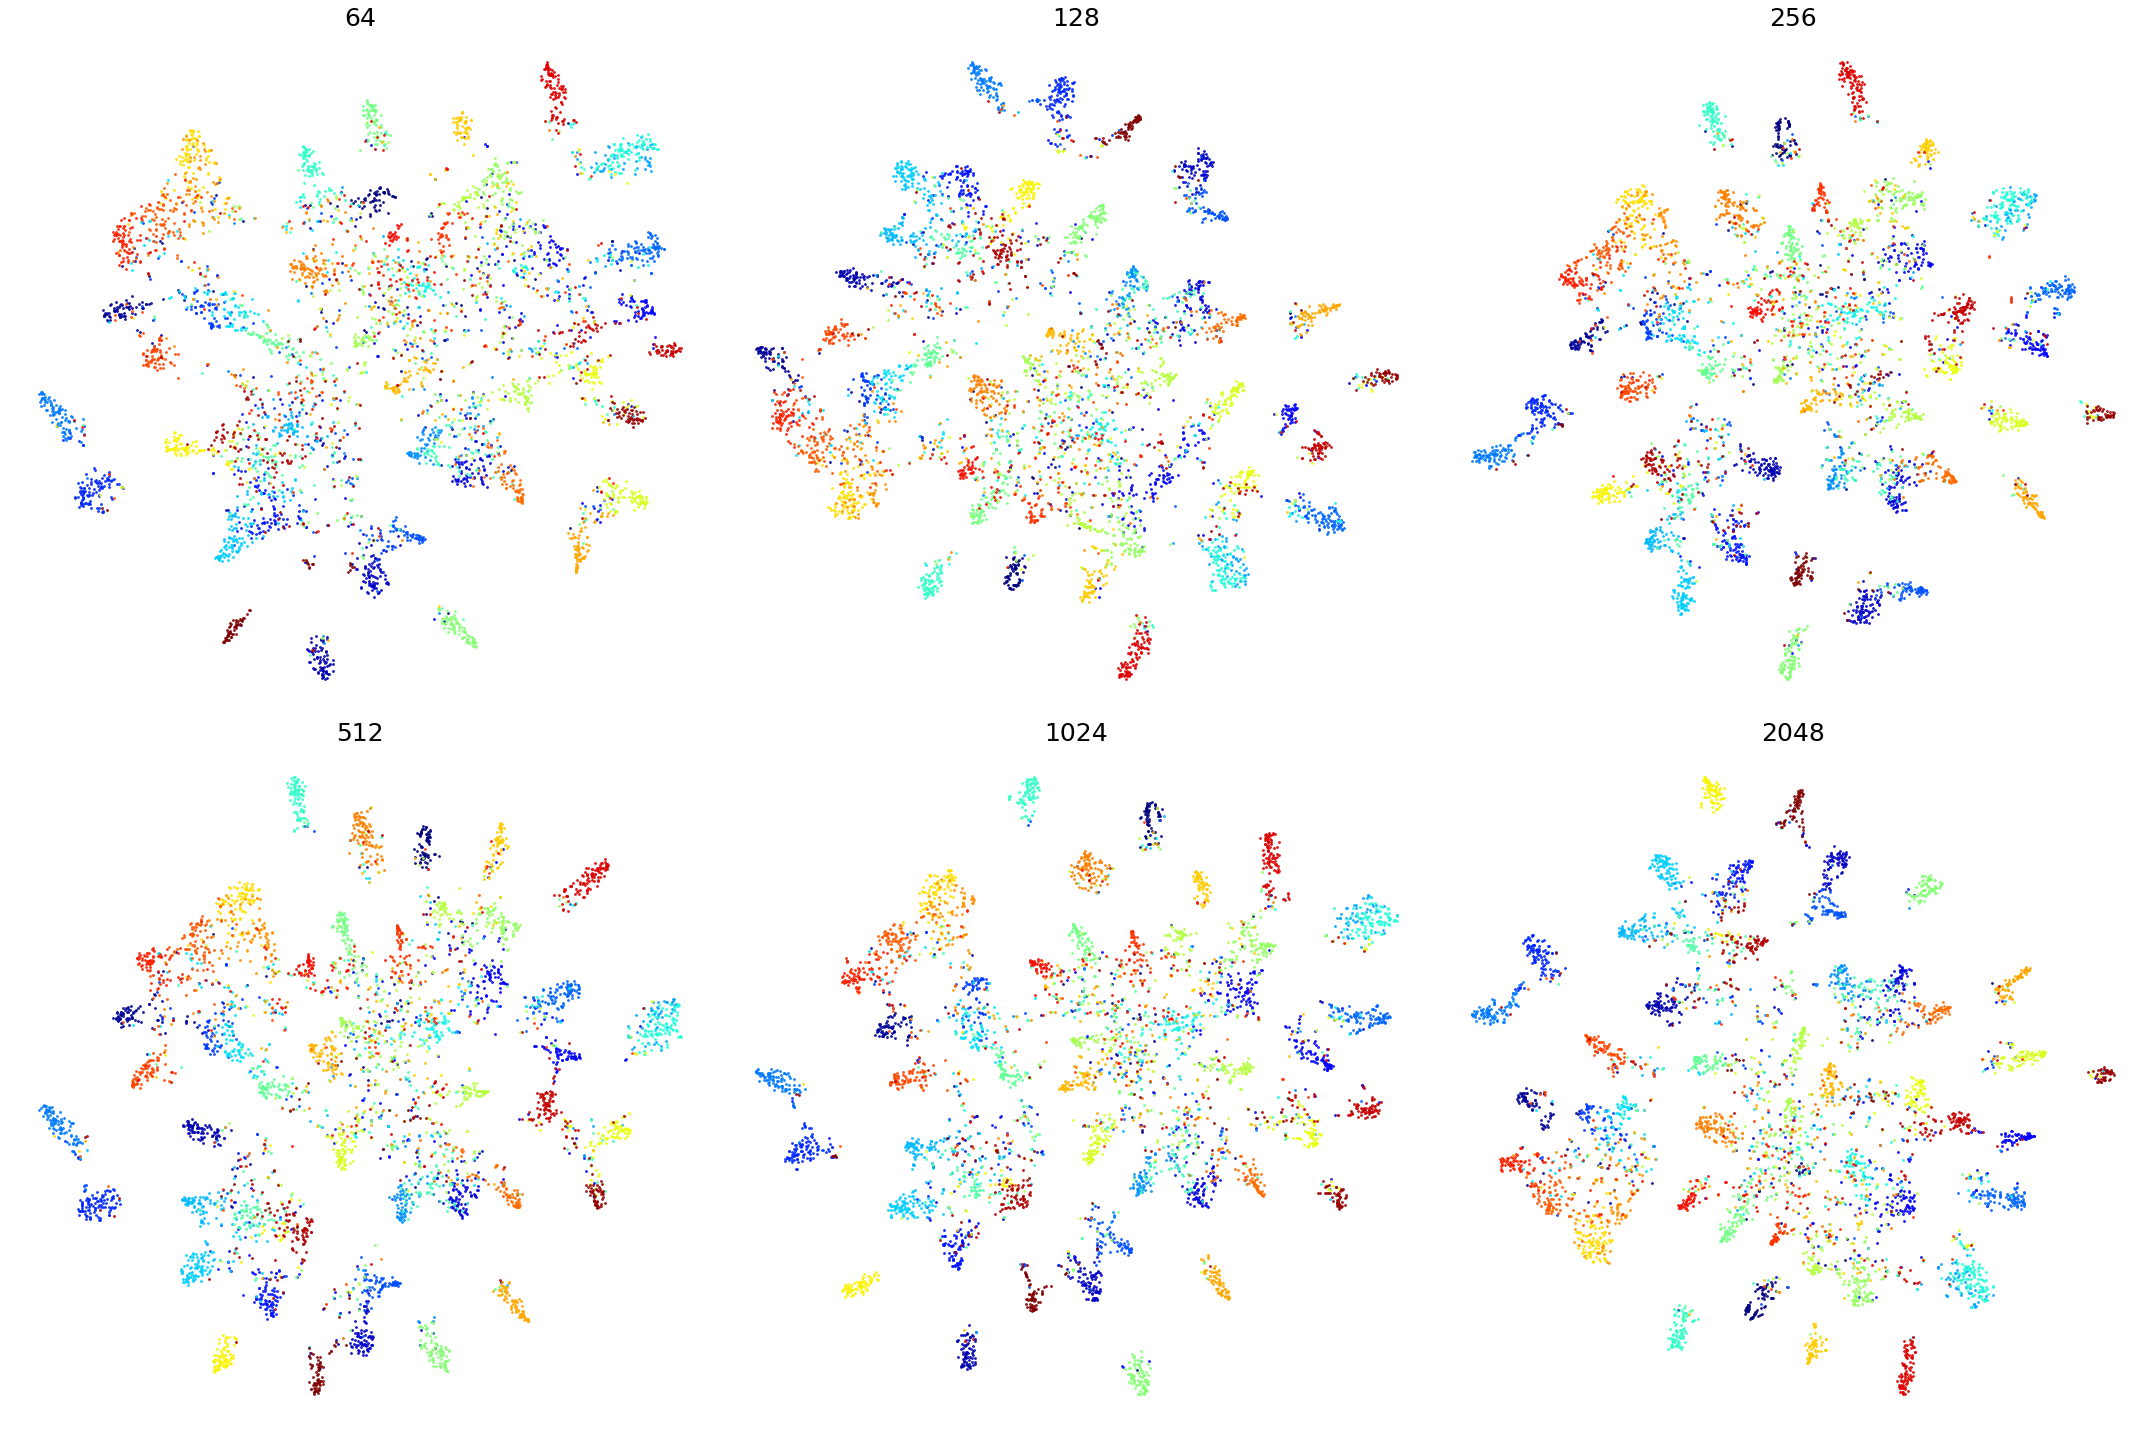

In [8]:
import matplotlib.pyplot as plt
from modules.plotting import plot_results

plot_results(results,"embedding_size")
plt.show()